<a href="https://colab.research.google.com/github/dashasmertina/-/blob/master/semi_supervised_classification_using_autoencoders_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv('/content/gdrive/My Drive/cr/creditcard.csv')
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24) #переводим в сутки
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# Набор данных состоит из 28 анонимизированных переменных, 1 переменной "количество", 
# 1 переменной "время" и 1 целевой переменной - класса. Распределение целей представлено ниже.
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [32]:
# 1000 строк транзакций, не связанных с мошенничеством.
non_fraud = data[data['Class'] == 0].sample(1000) 
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


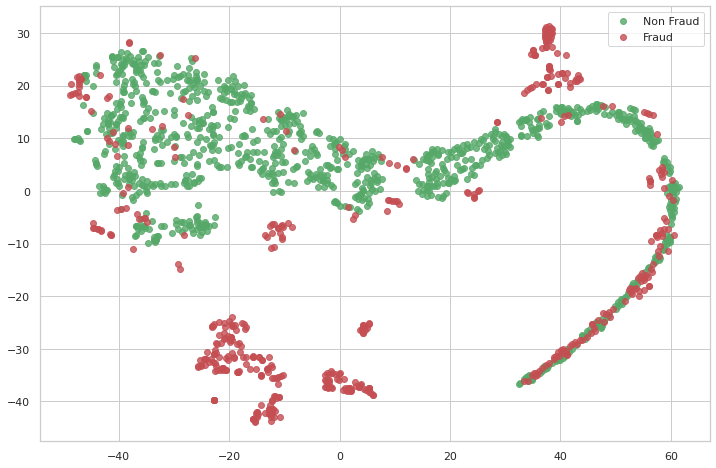

In [33]:
# Визуализация мошеннических и не мошеннических транзакции
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [34]:
# Модель автоэнкодера, в которой мы показываем только случаи, не связанные с мошенничеством. 
# input layer 
input_layer = Input(shape=(X.shape[1],))

# encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [35]:
#архитектура модели, скомпилировав входной и выходной слои. Добавлены оптимизатор и функция потерь, 
#Используется "adadelta" в качестве оптимизатора и "mse" в качестве функции потерь.
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [36]:
autoencoder.summary()#слои

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_10 (Dense)            (None, 100)               3100      
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 100)               5100      
                                                                 
 dense_14 (Dense)            (None, 30)                3030      
                                                                 
Total params: 18,830
Trainable params: 18,830
Non-trainable

In [37]:
#Перед тренировкой выполняем минимальное максимальное масштабирование, чтобы сделать числовые диапозоны от 0 до 1, чтобы быстрее были вычисления
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [38]:
#используем 2000 строк случаев, не связанных с мошенничеством, для обучения автоэнкодера
autoencoder.fit(x_norm[0:3000], x_norm[0:3000], 
                batch_size = 256, epochs = 20, 
                shuffle = True, validation_split = 0.20);

Epoch 1/20
10/10 [==============================] - 1s 19ms/step - loss: 0.2417 - val_loss: 0.2413
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.2412 - val_loss: 0.2408
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.2406 - val_loss: 0.2402
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 0.2400 - val_loss: 0.2396
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.2394 - val_loss: 0.2391
Epoch 6/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2389 - val_loss: 0.2385
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2383 - val_loss: 0.2379
Epoch 8/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2377 - val_loss: 0.2373
Epoch 9/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2371 - val_loss: 0.2367
Epoch 10/20
10/10 [==============================] - 0s 7ms/step - loss: 0.2365 - val_loss: 0.2361
Epoch 11/20
10/10 

In [39]:
#скрытые представления входных данных, полученных с помощью модели
#создадим еще одну сеть, содержащую последовательные слои, добавляем обученные веса только до третьего слоя, где существует скрытое представление.
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [40]:
#Генерируем скрытые представления двух классов: без мошенничества и мошенничества
# прогнозируя исходные данные с использованием приведенной выше модели.
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


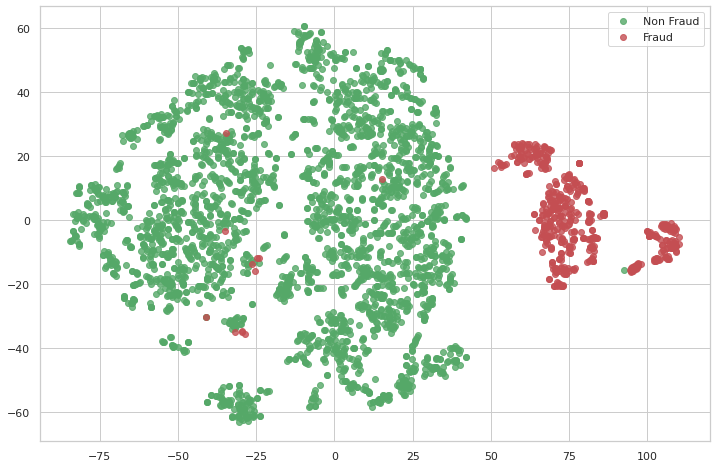

In [41]:
#Теперь создаем обучающий набор данных, используя полученные скрытые представления, визуализируем случаи
#мошенничества по сравнению со случаями, не связанными с мошенничеством.
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [42]:
# обучить простой линейный классификатор на основе набора данных.
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       0.99      0.91      0.95       131

    accuracy                           0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.98       873


Accuracy Score:  0.9851088201603666
